In [ ]:
import yfinance as yf
import pandas as pd

# Herunterladen der historischen Daten des iShares MSCI World ETF (URTH)
ticker = 'URTH'
data = yf.download(ticker, start='2000-01-01', end='2025-01-01')

# Wir verwenden nur den End-Kurs.
data = data[['Close']]
data.rename(columns={'Adj Close': 'MSCI_World_Index'}, inplace=True)

print(data.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price           Close
Ticker           URTH
Date                 
2012-01-12  39.085308
2012-01-13  39.085308
2012-01-17  39.085308
2012-01-18  39.085308
2012-01-19  40.235329


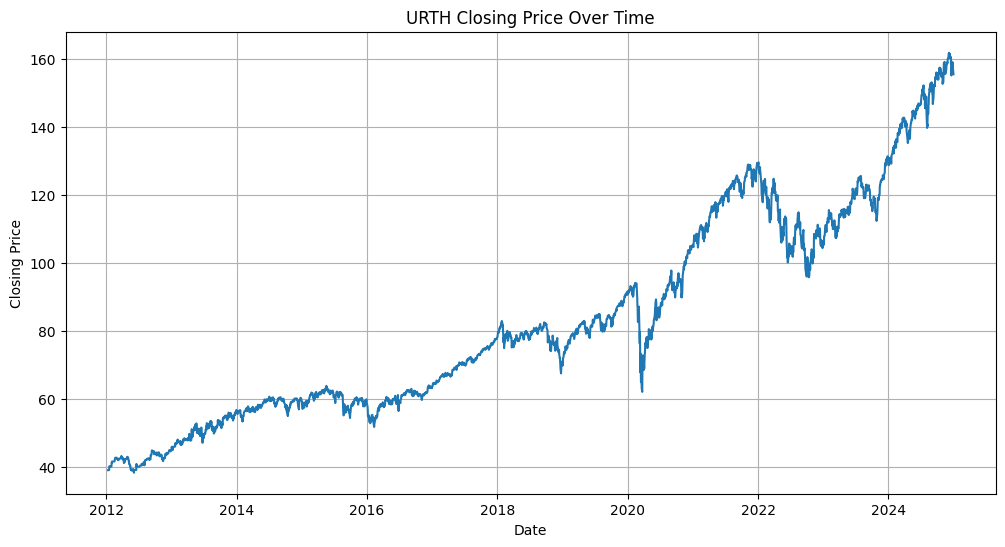

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'])
plt.title(f'{ticker} Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()


In [ ]:
split_index = int(len(data) * 0.7)

train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Anzeigen des Start- bzw. End-Datums
print("Training data start date:", train_data.index.min())
print("Training data end date:", train_data.index.max())
print("Test data start date:", test_data.index.min())
print("Test data end date:", test_data.index.max())

Training data shape: (2284, 1)
Test data shape: (979, 1)
Training data start date: 2012-01-12 00:00:00
Training data end date: 2021-02-09 00:00:00
Test data start date: 2021-02-10 00:00:00
Test data end date: 2024-12-31 00:00:00


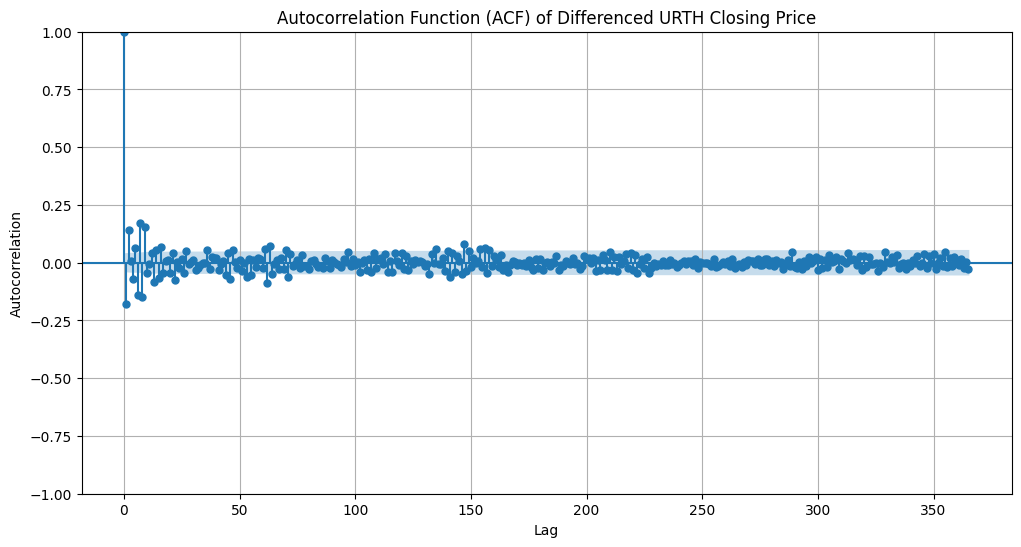

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

data_diff = train_data.diff().dropna()

plt.figure(figsize=(12, 6))
plot_acf(data_diff, lags=365, ax=plt.gca())
plt.title(f'Autocorrelation Function (ACF) of Differenced {ticker} Closing Price')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2284
Model:                ARIMA(25, 1, 5)   Log Likelihood               -2457.705
Date:                Sun, 18 May 2025   AIC                           4977.410
Time:                        11:19:25   BIC                           5155.141
Sample:                             0   HQIC                          5042.233
                               - 2284                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5038      0.245     -2.055      0.040      -0.984      -0.023
ar.L2          0.6916      0.372      1.857      0.063      -0.038       1.422
ar.L3          0.9525      0.253      3.771      0.0

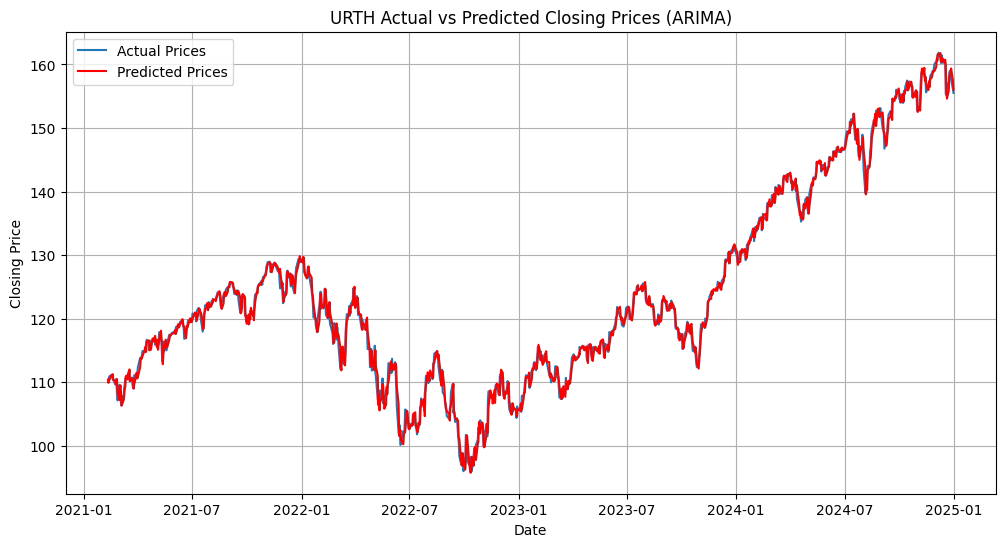

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Trainieren des ARIMA Modells.
model = ARIMA(train_data.to_numpy(), order=(25, 1, 5))
model_fit = model.fit()

print(model_fit.summary())

# Erstellen von (Next-Day Predictions)
predictions = []

np_test_data = test_data.to_numpy()
for i in range(len(test_data)):
  prediction = model_fit.forecast()
  model_fit = model_fit.append([np_test_data[i]], refit=False)
  predictions.append(prediction)

mse = mean_squared_error(test_data.to_numpy(), predictions)
print(f'MSE: {mse}')

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data.to_numpy(), label='Actual Prices')
plt.plot(test_data.index, predictions, color='red', label='Predicted Prices')
plt.title(f'{ticker} Actual vs Predicted Closing Prices (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Berechnen des Zeitraums der Testdaten
test_start_year = test_data.index.min()
test_end_year = test_data.index.max()

number_of_years = test_end_year - test_start_year

test_data_length = number_of_years.days/365.0

1374.7959365844727


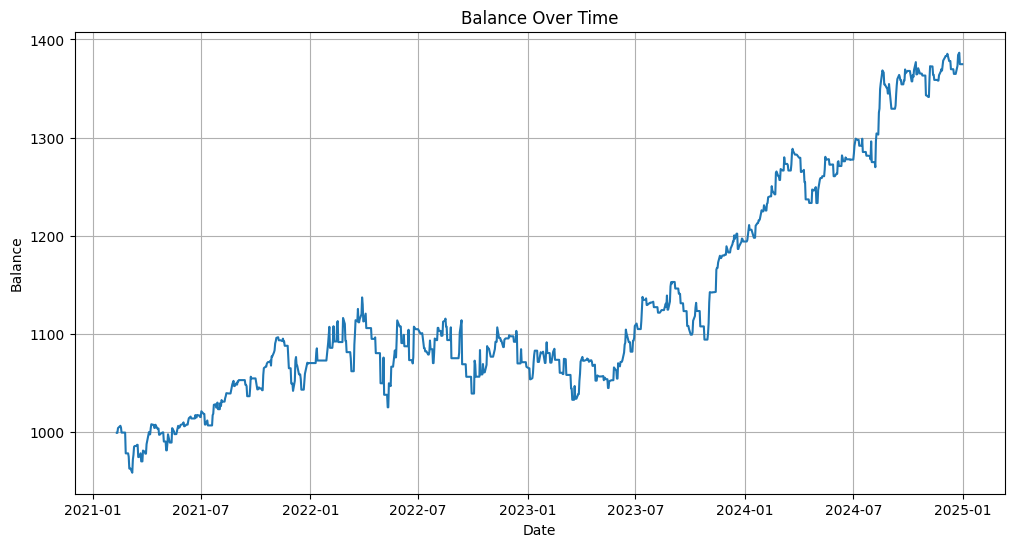

Rendite 9.633839215023416 %


1374.7959365844727

In [ ]:
# Jetzt lass uns eine Simulation start, um zu prüfen, welchen Gewinn wir erwarten
# können.
def simulate_strategy(data, predictions, last_price, balance = 1000):
  value_history = []
  shares = 0;
  last_prediction = last_price

  for i in range(len(predictions)):
    # Wenn der Peis steigt, kaufen wir neue Aktien.
    if(predictions[i] > last_prediction):
      new_shares = balance // last_price
      balance -= new_shares * last_price
      shares += new_shares

    # Wenn der Preis fällt, verkaufen wir sie wieder.
    else:
      balance += shares * last_price
      shares = 0

    last_price = np_test_data[i][0]
    last_prediction = predictions[i]
    value_history.append(balance + shares * last_price)

  print(balance)
  plt.figure(figsize=(12, 6))
  plt.plot(test_data.index.to_numpy()[list(range(len(data)))], value_history)
  plt.title(f'Balance Over Time')
  plt.xlabel('Date')
  plt.ylabel('Balance')
  plt.grid(True)
  plt.show()

  print("Rendite", 100*(balance/1000-1)/ test_data_length, "%")

  return balance.item()

simulate_strategy(test_data.to_numpy(), predictions, train_data.to_numpy()[-1][0])

Epoch 1/3
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0605 - val_loss: 0.0122
Epoch 2/3
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0076 - val_loss: 0.0115
Epoch 3/3
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0055 - val_loss: 0.0020
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
LSTM MSE: 11.715996742248535


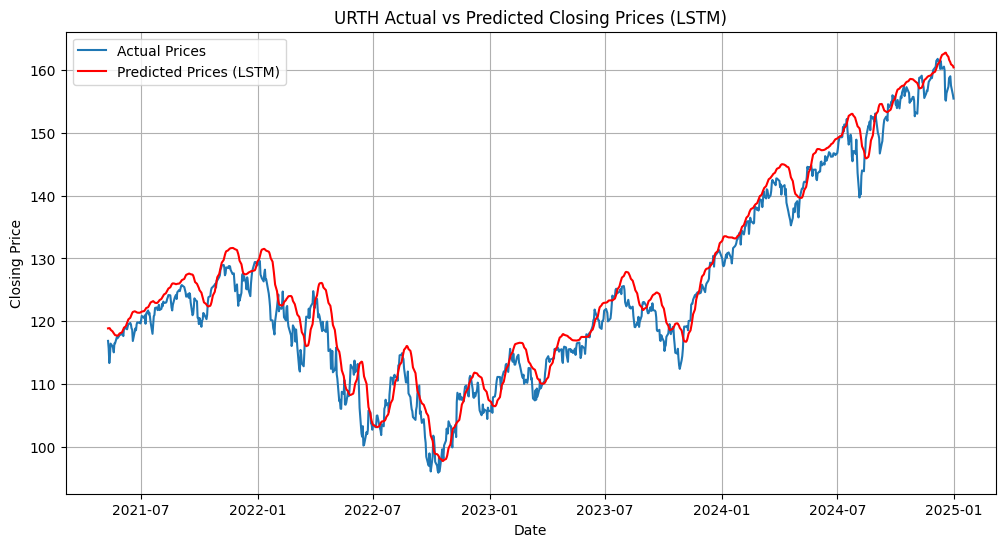

1406.9377365112305


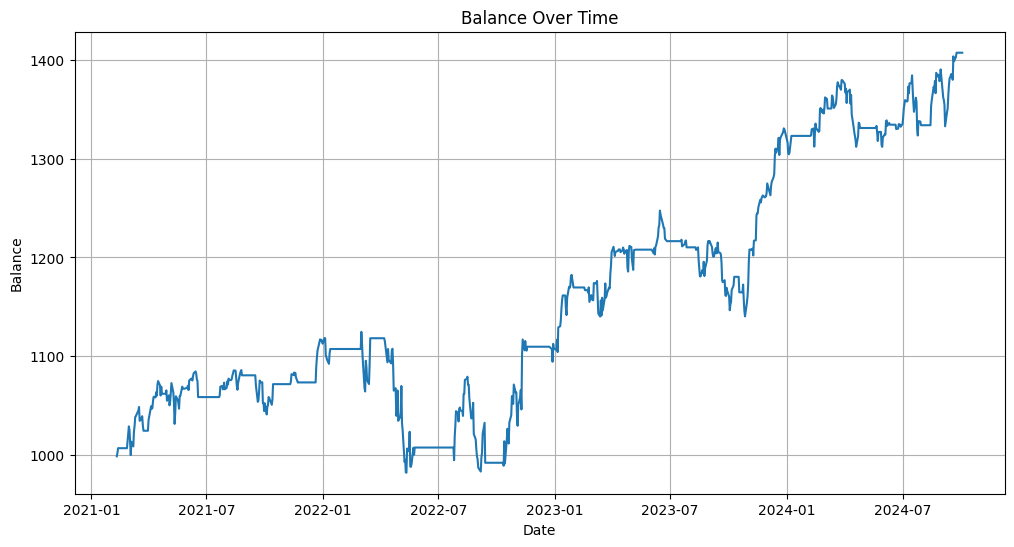

Rendite 10.46001928356332 %


1406.9377365112305

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Skalieren der Daten
scaler = MinMaxScaler(feature_range=(0, 1))

# Erstellen des Trainings- und Testdatensatzes.
train_data_scaled = scaler.fit_transform(train_data.to_numpy().reshape(-1, 1))
test_data_scaled = scaler.transform(test_data.to_numpy().reshape(-1, 1))

# Erstellen der Sequenzen.
def create_dataset(dataset, look_back=1):
  X, Y = [], []
  for i in range(len(dataset) - look_back - 1):
    a = dataset[i:(i + look_back), 0]
    X.append(a)
    Y.append(dataset[i + look_back, 0])
  return np.array(X), np.array(Y)

look_back = 60  # Anzahl der vorhergehenden Zeitschritte.
X_train, y_train = create_dataset(train_data_scaled, look_back)
X_test, y_test = create_dataset(test_data_scaled, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Bauen des Modells
model_lstm = Sequential()
model_lstm.add(Input((look_back, 1)))
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Trainieren des Modells. (ACHTUNG: Testdaten werden hier als Validierungsdaten
# verwendet, nicht optimal aber da keine Entscheidungen basierend auf den Daten
# getroffen werden, ist das für ein so kleines Bsp. ok)
model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test),  epochs=3, batch_size=32)

predictions_scaled = model_lstm.predict(X_test)
predictions_lstm = scaler.inverse_transform(predictions_scaled)

rmse_lstm = mean_squared_error(test_data['Close'][look_back+1:], predictions_lstm)
print(f'LSTM MSE: {rmse_lstm}')

plt.figure(figsize=(12, 6))
plt.plot(test_data.index[look_back+1:], test_data['Close'][look_back+1:], label='Actual Prices')
plt.plot(test_data.index[look_back+1:], predictions_lstm, color='red', label='Predicted Prices (LSTM)')
plt.title(f'{ticker} Actual vs Predicted Closing Prices (LSTM)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

simulate_strategy(test_data.to_numpy()[look_back+1:], predictions_lstm, train_data.to_numpy()[-1][0])
